# 1 Import Libraries



In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import to_datetime
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# 2 Load Data

In [2]:
# Mengambil file
file_path = 'household_power_consumption.txt'

# Mengambil data dari file
# Menggabungkan kolom Date & Time
df = pd.read_csv(file_path, sep=';', dayfirst=True,
                 infer_datetime_format=True,
                 low_memory=False, na_values=['nan', '?'])

df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


# 3 Preprocess Data

In [3]:
# Menggabungkan kolom Date & Time
df['Datetime'] = pd.to_datetime(df['Date'] + " " + df['Time'])

df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00


In [4]:
df.to_csv('house_consumption_melted.csv', index=False)

# 4 Model Build

## Process Melted Dataset

In [39]:
# Ambil Data
df = pd.read_csv('house_consumption_melted.csv', sep=',', infer_datetime_format=True, header=0)

# Convert 'Datetime' column to datetime type
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Set 'Datetime' as the index
df.set_index('Datetime', inplace=True)

# Group by minute and then resample into 1-hour frequency while summing 'Sub_metering_3'
df_agg = df.resample('1H').agg({'Sub_metering_3': 'sum'})

df_agg

,Sub_metering_3
Datetime,
2006-12-16 17:00:00,607.0
2006-12-16 18:00:00,1012.0
2006-12-16 19:00:00,1001.0
2006-12-16 20:00:00,1007.0
2006-12-16 21:00:00,1033.0
...,...
2010-12-11 19:00:00,788.0
2010-12-11 20:00:00,604.0
2010-12-11 21:00:00,0.0


## Select the Relevant Data

In [40]:
# Select relevant columns
data = df_agg[['Sub_metering_3']]

# Print the result
print(data)

                     Sub_metering_3
Datetime                           
2006-12-16 17:00:00           607.0
2006-12-16 18:00:00          1012.0
2006-12-16 19:00:00          1001.0
2006-12-16 20:00:00          1007.0
2006-12-16 21:00:00          1033.0
...                             ...
2010-12-11 19:00:00           788.0
2010-12-11 20:00:00           604.0
2010-12-11 21:00:00             0.0
2010-12-11 22:00:00             0.0
2010-12-11 23:00:00             0.0

[34951 rows x 1 columns]


## Normalize Data

In [41]:
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

print(data_normalized)

[[0.46945089]
 [0.78267595]
 [0.7741686 ]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]


## Create Sequences

In [42]:
# Function to create input sequences and labels
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [43]:
BATCH_SIZE = 25
sequence_length = 24

# Create sequences and labels
X, y = create_sequences(data_normalized, sequence_length)

## Splits The Data

In [45]:
split_time = int(len(data) * 0.8)
train_data, test_data = X[:split_time], X[split_time:]
train_target, test_target = y[:split_time], y[split_time:]

array([[[0.05877804],
        [0.05568445],
        [0.67130704],
        ...,
        [0.89636504],
        [0.870843  ],
        [0.89095128]],

       [[0.05568445],
        [0.67130704],
        [0.05955143],
        ...,
        [0.870843  ],
        [0.89095128],
        [0.86001547]],

       [[0.67130704],
        [0.05955143],
        [0.10054138],
        ...,
        [0.89095128],
        [0.86001547],
        [0.24439288]],

       ...,

       [[0.23743233],
        [0.12683681],
        [0.03016241],
        ...,
        [0.        ],
        [0.60943542],
        [0.4671307 ]],

       [[0.12683681],
        [0.03016241],
        [0.42614076],
        ...,
        [0.60943542],
        [0.4671307 ],
        [0.        ]],

       [[0.03016241],
        [0.42614076],
        [0.        ],
        ...,
        [0.4671307 ],
        [0.        ],
        [0.        ]]])

In [46]:
# Reshape data for LSTM (samples, time steps, features)
train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], 1))
train_target = train_target.reshape((train_target.shape[0], train_target.shape[1], 1))

## Build The Model

In [47]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(sequence_length, 1)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(24)
])

# Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 24, 64)            16896     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 20)                1300      
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 24)                264       
                                                                 
Total params: 51694 (201.93 KB)
Trainable params: 51694 (201.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Compile the Model

In [48]:
model.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=["mae"])

### Callback Function

In [49]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('mae') < 0.15:
            print('MAE terpenuhi')
            self.model.stop_training = True

### Train the Model

In [50]:
model.fit(train_data, train_target, epochs=300, batch_size=BATCH_SIZE, callbacks=[myCallback()])

Epoch 1/300
1119/1119 [==============================] - 36s 27ms/step - loss: 0.0383 - mae: 0.2169
Epoch 2/300
1119/1119 [==============================] - 30s 27ms/step - loss: 0.0317 - mae: 0.1933
Epoch 3/300
1119/1119 [==============================] - 30s 27ms/step - loss: 0.0310 - mae: 0.1897
Epoch 4/300
1119/1119 [==============================] - 31s 28ms/step - loss: 0.0305 - mae: 0.1870
Epoch 5/300
1119/1119 [==============================] - 30s 27ms/step - loss: 0.0300 - mae: 0.1847
Epoch 6/300
1119/1119 [==============================] - 32s 29ms/step - loss: 0.0294 - mae: 0.1820
Epoch 7/300
1119/1119 [==============================] - 31s 28ms/step - loss: 0.0284 - mae: 0.1774
Epoch 8/300
1119/1119 [==============================] - 31s 27ms/step - loss: 0.0275 - mae: 0.1734
Epoch 9/300
1119/1119 [==============================] - 30s 27ms/step - loss: 0.0270 - mae: 0.1705
Epoch 10/300
1119/1119 [==============================] - 30s 27ms/step - loss: 0.0266 - mae: 0.1692

### Test the Model

In [51]:
# Make predictions on test data
predictions = model.predict(test_data)

218/218 [==============================] - 3s 10ms/step


In [52]:
# Inverse transform predictions to original scale
predictions = scaler.inverse_transform(predictions)
test_target_inverse = scaler.inverse_transform(test_target)

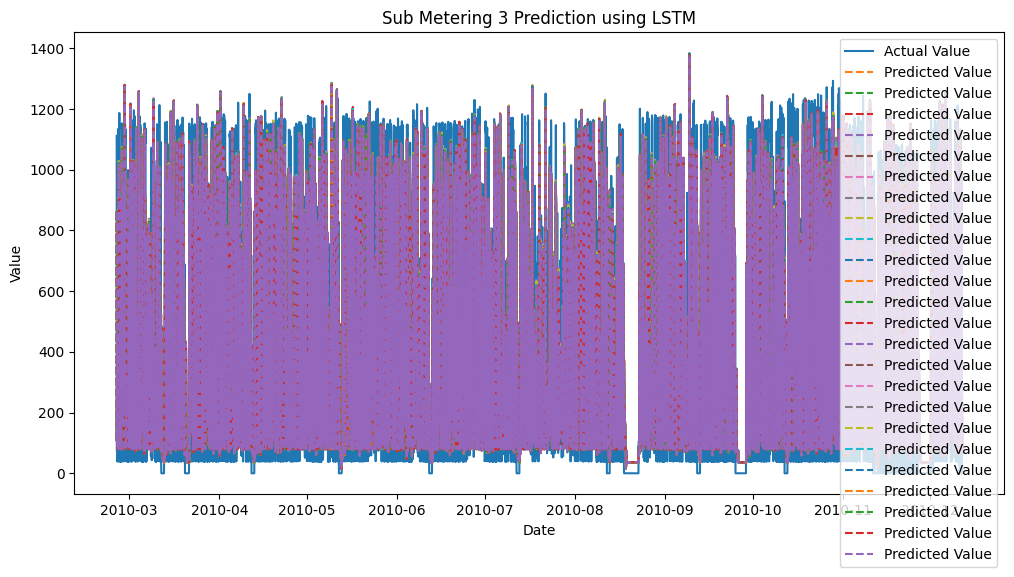

In [53]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df_agg.index[split_time+sequence_length:], test_target_inverse, label='Actual Value')
plt.plot(df_agg.index[split_time+sequence_length:], predictions, label='Predicted Value', linestyle='dashed')
plt.title('Sub Metering 3 Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

## Test On Real Data

In [56]:
# Mengambil file
test_path = 'data_temp_iot.txt'

# Mengambil data dari file
df = pd.read_csv(test_path)

df.head(24)

,kWh
0,97.53
1,116.15
2,145.71
3,88.55
4,31.33
5,3.12
6,3.30
7,4.46
8,3.14
9,4.26


In [57]:
# Select relevant columns
data = df[['kWh']]

data_arrayed = np.array(data)
# Print the result
print(data_arrayed)

[[ 97.53]
 [116.15]
 [145.71]
 [ 88.55]
 [ 31.33]
 [  3.12]
 [  3.3 ]
 [  4.46]
 [  3.14]
 [  4.26]
 [  4.79]
 [137.98]
 [112.78]
 [ 32.94]
 [ 54.67]
 [ 78.9 ]
 [ 23.45]
 [ 45.67]
 [ 89.01]
 [ 12.34]
 [ 67.89]
 [ 98.76]
 [ 34.56]
 [ 72.9 ]]


In [58]:
# Normalize the Data
data_normalized = scaler.fit_transform(data_arrayed)

# Print the generated data
print(data_normalized)

[[6.62108142e-01]
 [7.92692335e-01]
 [1.00000000e+00]
 [5.99130374e-01]
 [1.97839961e-01]
 [0.00000000e+00]
 [1.26236061e-03]
 [9.39757346e-03]
 [1.40262290e-04]
 [7.99495056e-03]
 [1.17119013e-02]
 [9.45788625e-01]
 [7.69058139e-01]
 [2.09131075e-01]
 [3.61526054e-01]
 [5.31453819e-01]
 [1.42576618e-01]
 [2.98408023e-01]
 [6.02356406e-01]
 [6.46609159e-02]
 [4.54239428e-01]
 [6.70734273e-01]
 [2.20492321e-01]
 [4.89375131e-01]]


In [59]:
X, y = create_sequences(data_normalized, 1)
X

array([[[6.62108142e-01]],

       [[7.92692335e-01]],

       [[1.00000000e+00]],

       [[5.99130374e-01]],

       [[1.97839961e-01]],

       [[0.00000000e+00]],

       [[1.26236061e-03]],

       [[9.39757346e-03]],

       [[1.40262290e-04]],

       [[7.99495056e-03]],

       [[1.17119013e-02]],

       [[9.45788625e-01]],

       [[7.69058139e-01]],

       [[2.09131075e-01]],

       [[3.61526054e-01]],

       [[5.31453819e-01]],

       [[1.42576618e-01]],

       [[2.98408023e-01]],

       [[6.02356406e-01]],

       [[6.46609159e-02]],

       [[4.54239428e-01]],

       [[6.70734273e-01]],

       [[2.20492321e-01]]])

In [60]:
predictions = model.predict(X)

1/1 [==============================] - 1s 867ms/step


In [61]:
predictions = scaler.inverse_transform(predictions)
# Print the predicted data
print("\nPredicted Data:")
print(predictions)


Predicted Data:
[[123.46093  123.389244 122.743675 122.667145 123.33261  123.0068
  123.01589  123.007996 122.9322   122.96072  122.93783  122.96554
  122.55447  123.78011  122.7054   123.41899  123.4436   123.64677
  122.65827  123.47162  123.00187  123.379395 122.99849  123.09154 ]
 [134.91167  134.85272  133.9262   133.89816  134.7801   134.3562
  134.32507  134.3251   134.24345  134.22276  134.16312  134.19351
  133.70804  135.29866  133.87584  134.82149  134.92464  135.18172
  133.85303  134.97585  134.3007   134.83954  134.34552  134.40338 ]
 [145.27678  145.22922  144.04803  144.06369  145.14212  144.62912
  144.56172  144.5689   144.48183  144.41673  144.32384  144.35672
  143.80353  145.72546  143.98677  145.14299  145.31705  145.62317
  143.98584  145.38931  144.52798  145.21303  144.61632  144.64253 ]
 [115.75295  115.673096 115.217766 115.10926  115.62736  115.36842
  115.40421  115.39109  115.31962  115.380806 115.3826   115.408356
  115.04857  116.02552  115.18765  115.7

# 5 Generate Save Model

## Save the Model

In [62]:
run_model = tf.function(lambda x: model(x))
# This is important, let's fix the input size.
STEPS = 1
INPUT_SIZE = 24
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([STEPS, INPUT_SIZE], model.inputs[0].dtype))

# model directory.
MODEL_DIR = "model_kWh_4"
model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()

## Convert the Model to TFLITE

In [63]:
import pathlib
tflite_model_file = pathlib.Path('model_kWh_4.tflite')
tflite_model_file.write_bytes(tflite_model)

213228